In [1]:
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer

/home/yilong/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet('../../data/cleaned_tom/hi_tom_train_2000.parquet')
dfh = pd.read_parquet('../../data/cleaned_tom/hi_tom_explore_tom_test_hint.parquet')

In [3]:
print(len(df), len(dfh))

2000 1600


In [4]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   deception       2000 non-null   bool  
 1   story_length    2000 non-null   int64 
 2   question_order  2000 non-null   int64 
 3   sample_id       2000 non-null   int64 
 4   story           2000 non-null   object
 5   question        2000 non-null   object
 6   choices         2000 non-null   object
 7   answer          2000 non-null   object
 8   question_old    2000 non-null   object
 9   answer_old      2000 non-null   object
 10  data_source     2000 non-null   object
 11  prompt          2000 non-null   object
 12  ability         2000 non-null   object
 13  reward_model    2000 non-null   object
 14  extra_info      2000 non-null   object
dtypes: bool(1), int64(3), object(11)
memory usage: 220.8+ KB


In [6]:
dfs = df.groupby(['answer']).story.count().reset_index()

In [7]:
dfs = dfs.sort_values(by='story', ascending=False, ignore_index=True)
dfs.head(20)

,answer,story
0,blue_drawer,84
1,green_basket,82
2,red_drawer,80
3,red_bottle,79
4,green_bottle,77
5,green_box,77
6,blue_bucket,75
7,blue_treasure_chest,74
8,red_bucket,73
9,green_suitcase,73


In [13]:
#SYSTEM_PROMPT = """You are a helpful assistant. First, think through the question internally before providing the final answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> step by step reasoning here </think><answer> answer here </answer>"""

#SYSTEM_PROMPT = """You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>."""

SYSTEM_PROMPT = """Please reason step by step, and put your final answer within <answer> </answer> tags"""

In [14]:
XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [41]:
def get_prompts(dft):
    prompt = []
    for i in range(len(dft)):
        if dft['data_source'][i] == 'explore_tom':
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story_structure'][i], dft['question'][i])}
                ])
        else:
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story'][i], dft['question'][i])}
                ])
    return prompt

In [42]:
prompts = get_prompts(df)
df['prompt'] = prompts

prompts = get_prompts(dfh)
dfh['prompt'] = prompts

In [43]:
data = Dataset.from_pandas(df)

In [44]:
len(data['prompt'])

2000

<Axes: ylabel='Count'>

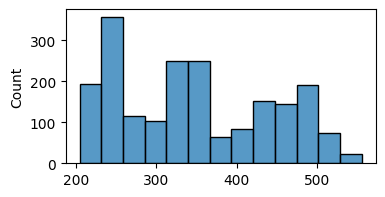

In [45]:
token_lengths = []
for prompt_list in data['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    # Tokenize the content
    tokens = tokenizer.apply_chat_template(prompt_list)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [46]:
data_train = Dataset.from_pandas(df)
data_test = Dataset.from_pandas(dfh)

In [47]:
data_train

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info'],
    num_rows: 2000
})

In [48]:
data_test

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info', 'story_structure', 'infilled_story', 'question_type', 'params', 'nth_order', 'is_interesting', 'story_type', 'story_structure_wn'],
    num_rows: 1600
})

In [49]:
data_train.to_parquet('../data/train/ToM_train.parquet')
data_test.to_parquet('../data/test/ToM_test.parquet')

Creating parquet from Arrow format: 100%|██████████| 2/2 [00:00<00:00, 255.04ba/s]


7776299

In [32]:
data_train['answer'][0]

'green_cupboard'

In [29]:
import re

In [30]:
def extract_xml_answer(text: str) -> str:
    answer_pattern = r'<answer>(.*?)</answer>'
    matches = list(re.finditer(answer_pattern, text, re.DOTALL))
    if not matches:
        return None
        
    final_answer = matches[-1].group(1).strip()
    return final_answer



def normalize_answer(answer: str) -> str:
    """Normalizes the answer text for better comparison.
    Args:
        answer: Raw answer text
    Returns:
        Normalized answer text
    """
    # Convert to lowercase
    normalized = answer.lower()
    # Remove extra whitespace
    normalized = re.sub(r'\s+', ' ', normalized).strip()
    # Remove punctuation that doesn't affect meaning
    normalized = re.sub(r'[.,;:!?]', '', normalized)
    return normalized




def reward_func_(response, answer):
    pattern = r"^<think>.*?</think>\s*<answer>.*?</answer>$"
    match = re.match(pattern, response, re.DOTALL | re.MULTILINE)
    
    if match:
        response_ = extract_xml_answer(response)
        norm_response = normalize_answer(response_)
        norm_answer = normalize_answer(answer)
        ans_pattern = r"\b(?:in|at|on|inside)?\s*(?:the\s*)?" + re.escape(norm_answer) + r"\b$"
        match = re.match(ans_pattern, norm_response, re.DOTALL | re.MULTILINE)
        if match:
            return 2
        else:
            return 0.5
    else:
        return 0


In [31]:
answer = "<think>think</think><answer>airport terminal gate</answer>"
answer_wrong = "<think>think</think><answer>(2) at the  . 'airport gate'\n </answer>"
answer_p1 = "<think>think</think><answer>'airport terminal gate area.</answer>"
answer_p2 = "<think>think</think><answer>in airport terminal gate.</answer>"

In [33]:
reward_func_(answer, 'airport terminal gate')

2

In [34]:
reward_func_(answer_wrong, 'airport terminal gate')

0.5

In [35]:
reward_func_(answer_p1, 'airport terminal gate')

0.5

In [36]:
reward_func_(answer_p2, 'airport terminal gate')

2